In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

#Data Loading

In [ ]:

# Load the dataset
df = pd.read_csv('AQI_19-24(test).csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Check for missing values and fill or drop
df.dropna(inplace=True)
df.head()

,AQI
date,
2019-01-01,138.335417
2019-01-02,136.497038
2019-01-03,140.986804
2019-01-04,131.428163
2019-01-05,135.004868


#Feature Addition

In [ ]:
def add_features(data, lags=5, rolling_window=3):
    for lag in range(1, lags + 1):
        data[f'AQI_Lag_{lag}'] = data['AQI'].shift(lag)
    data['AQI_Rolling_Mean'] = data['AQI'].rolling(rolling_window).mean()
    data['AQI_Rolling_Std'] = data['AQI'].rolling(rolling_window).std()
    return data

df = add_features(df)
df.dropna(inplace=True)

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


#Preprocessing

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.drop('AQI', axis=1))
test_scaled = scaler.transform(test.drop('AQI', axis=1))
target_scaler = MinMaxScaler()
train_target_scaled = target_scaler.fit_transform(train[['AQI']])
test_target_scaled = target_scaler.transform(test[['AQI']])

#Preparing data for LSTM

In [ ]:
def prepare_data(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i, :])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_train, y_train = prepare_data(train_scaled, train_target_scaled, time_steps)
X_test, y_test = prepare_data(test_scaled, test_target_scaled, time_steps)


# HYPERPARAMATER TUNING ,MODEL TRANING AND EVALUATIONS

Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.001, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.001, batch_size=16, epochs=50
Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.001, batch_size=32, epochs=20
Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.001, batch_size=32, epochs=50
Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.01, batch_size=16, epochs=20
Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.01, batch_size=16, epochs=50
Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.01, batch_size=32, epochs=20
Testing combination: units=32, dropout_rate=0.2, optimizer=adam, learning_rate=0.01, batch_size=32, epochs=50
Testing combination: units=32, dropout_rate=0.2, optimizer=sgd, learning_rate=0.001, batch_size=16, epochs=20
Testing combination: units=32, dropout_rate=0.2, optimizer=sgd, learning_rate=0.001, batch_size=16, epochs=50
Testing

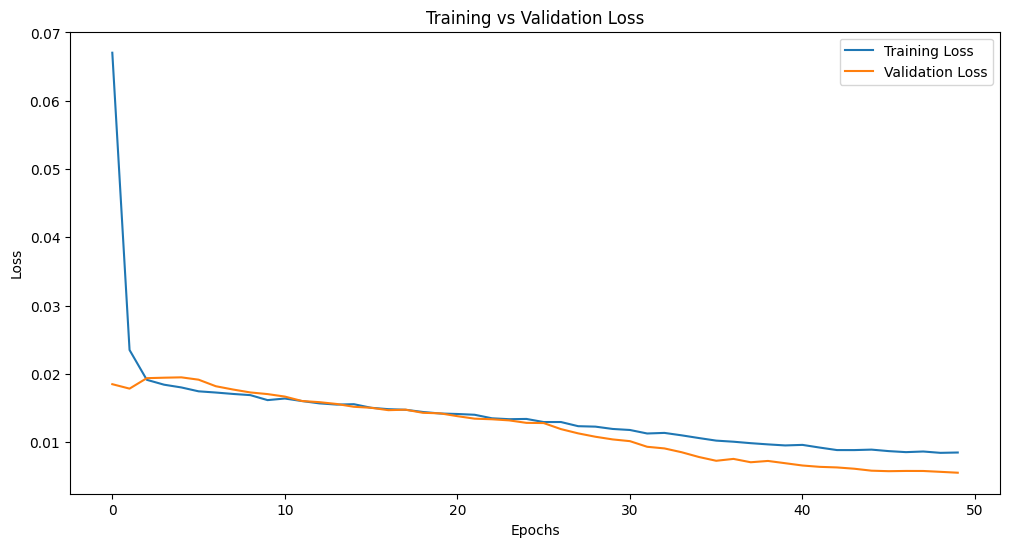

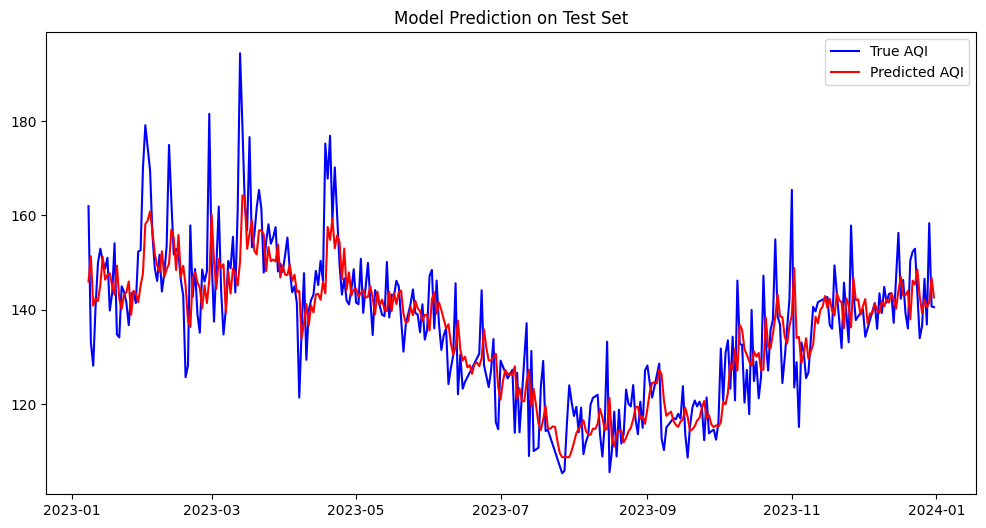

In [ ]:

def build_lstm(units, dropout_rate, optimizer, learning_rate):
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 2, activation='tanh'),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    optimizer_fn = tf.keras.optimizers.Adam(learning_rate=learning_rate) if optimizer == 'adam' else tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_fn, loss='mse')
    return model


# Hyperparameter Tuning (Manual Grid Search)

param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [20, 50]
}

best_score = float('inf')
best_params = None
best_model = None

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for learning_rate in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        print(f"Testing combination: units={units}, dropout_rate={dropout_rate}, optimizer={optimizer}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
                        model = build_lstm(units, dropout_rate, optimizer, learning_rate)
                        history = model.fit(
                            X_train, y_train,
                            validation_split=0.2,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
                        )
                        val_loss = min(history.history['val_loss'])
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }
                            best_model = model

print(f"Best Parameters: {best_params}")
print(f"Best Validation Loss: {best_score}")


# Evaluate Best Model

y_pred = best_model.predict(X_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test)

# Evaluation metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Custom Percentage Error
def percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

percentage_err = percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"Percentage Error: {percentage_err:.2f}%")


# Visualizations

# Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Prediction vs True
plt.figure(figsize=(12, 6))
plt.plot(test.index[-len(y_test_rescaled):], y_test_rescaled, label='True AQI', color='blue')
plt.plot(test.index[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted AQI', color='red')
plt.legend()
plt.title('Model Prediction on Test Set')
plt.show()


#Future Forecasting


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

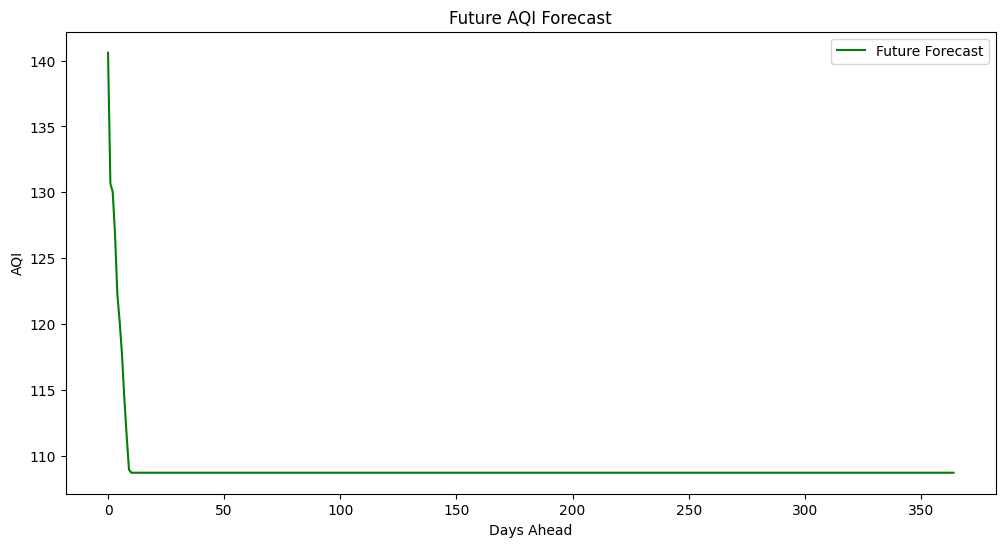

In [ ]:
def forecast_future(model, data, time_steps, n_steps, scaler):
    predictions = []
    input_seq = data[-time_steps:, :]

    for _ in range(n_steps):
        pred = model.predict(input_seq.reshape(1, time_steps, -1))
        predictions.append(pred[0, 0])

        pred_reshaped = pred.reshape(1, -1)
        if input_seq.shape[1] > 1:
            pred_reshaped = np.tile(pred_reshaped, (1, input_seq.shape[1]))

        input_seq = np.vstack((input_seq[1:], pred_reshaped))

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

future_steps = 365
future_forecast = forecast_future(best_model, test_scaled, time_steps, future_steps, target_scaler)

plt.figure(figsize=(12, 6))
plt.plot(range(future_steps), future_forecast, label='Future Forecast', color='green')
plt.legend()
plt.title('Future AQI Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('AQI')
plt.show()
